In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

import multiprocessing as mp
from tqdm import tqdm

import json
import matplotlib.pyplot as plt

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carga de datos

In [2]:
train_data = pd.read_csv("data/train.csv")
metadata = pd.read_csv("data/supplemental_metadata.csv")
char_to_pred = json.load(open("data/character_to_prediction_index.json", "r"))

In [3]:
train_data.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


# Analisis Exploratorio

In [4]:
print("--------------------Train data--------------------")
print(f"Cantidad de filas : {train_data.shape[0]}")
print(f"Cantidad de participantes : {train_data.participant_id.nunique()}")
print(f"Cantidad de frases unicas : {train_data.phrase.nunique()}")

--------------------Train data--------------------
Cantidad de filas : 67208
Cantidad de participantes : 94
Cantidad de frases unicas : 46478


In [5]:
print("--------------------Metadata--------------------")
print(f"Cantidad de filas : {metadata.shape[0]}")
print(f"Cantidad de participantes : {metadata.participant_id.nunique()}")
print(f"Cantidad de frases unicas : {metadata.phrase.nunique()}")

--------------------Metadata--------------------
Cantidad de filas : 52958
Cantidad de participantes : 72
Cantidad de frases unicas : 508


In [6]:
train_data.describe()

,file_id,sequence_id,participant_id
count,6.720800e+04,6.720800e+04,67208.000000
mean,1.094448e+09,1.072696e+09,119.758154
std,6.395616e+08,6.177372e+08,74.330468
min,5.414471e+06,7.109500e+04,0.000000
25%,5.277082e+08,5.376519e+08,63.000000
50%,1.099408e+09,1.074387e+09,113.000000
75%,1.662743e+09,1.605592e+09,178.000000
max,2.118949e+09,2.147465e+09,254.000000


# Levenshtein Distance
* Ref: https://blog.paperspace.com/implementing-levenshtein-distance-word-autocomplete-autocorrect/#:~:text=The%20Levenshtein%20distance%20is%20a,transform%20one%20word%20into%20another.

In [7]:
def printDistances(distances, token1Length, token2Length):
    for t1 in range(token1Length + 1):
        for t2 in range(token2Length + 1):
            print(int(distances[t1][t2]), end=" ")
        print()

def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    printDistances(distances, len(token1), len(token2))
    return distances[len(token1)][len(token2)]

In [8]:
# levenshteinDistanceDP("kelm", "hello")

# Preprocesamiento del Modelo

Solo se obtienen 20 indices de las coordenadas x y y, ya que son las unicas que han sido altamente entrenadas del modelo mediapipe de Google

In [9]:
def get_needed_cols():
    cols = []

    for i in range(20):
        cols.append(f'x_right_hand_{i}')
        cols.append(f'y_right_hand_{i}')
        cols.append(f'x_left_hand_{i}')
        cols.append(f'y_left_hand_{i}')
    
    return cols

In [10]:
selected_columns = get_needed_cols()
sample = pd.read_parquet("data/train_landmarks/1019715464.parquet", columns=selected_columns)

In [11]:
sample.head()

,x_right_hand_0,y_right_hand_0,x_left_hand_0,y_left_hand_0,x_right_hand_1,y_right_hand_1,x_left_hand_1,y_left_hand_1,x_right_hand_2,y_right_hand_2,...,x_left_hand_17,y_left_hand_17,x_right_hand_18,y_right_hand_18,x_left_hand_18,y_left_hand_18,x_right_hand_19,y_right_hand_19,x_left_hand_19,y_left_hand_19
sequence_id,,,,,,,,,,,,,,,,,,,,,
1975433633,0.223376,0.755344,NaN,NaN,0.314379,0.755479,NaN,NaN,0.381249,0.726833,...,NaN,NaN,0.105947,0.612873,NaN,NaN,0.093977,0.584119,NaN,NaN
1975433633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975433633,0.229610,0.763030,NaN,NaN,0.323558,0.757111,NaN,NaN,0.391224,0.726754,...,NaN,NaN,0.107829,0.601616,NaN,NaN,0.098407,0.567502,NaN,NaN
1975433633,0.233477,0.764909,NaN,NaN,0.324557,0.758571,NaN,NaN,0.396712,0.725978,...,NaN,NaN,0.112081,0.599290,NaN,NaN,0.102222,0.565760,NaN,NaN
1975433633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Modelo

In [12]:
s = pd.read_parquet('./data/train_landmarks/1019715464.parquet', columns=selected_columns)

parquets = ["128822441.parquet"]
# parquets = ["128822441.parquet", "149822653.parquet", "152029243.parquet", "169560558.parquet",
#             "175396851.parquet", "1019715464.parquet", "1021040628.parquet", "1098899348.parquet"]
for parquet in parquets:
    s2 = pd.read_parquet(f'./data/train_landmarks/{parquet}', columns=selected_columns)
    # Concatenate the dataframes
    s = pd.concat([s, s2])


s.index.unique()


Int64Index([1975433633, 1975473601, 1975502450, 1975521182, 1975541698,
            1975562925, 1975572309, 1975589819, 1975645112, 1975681715,
            ...
             228089325,  228121127,  228161302,  228193945,  228249271,
             228257007,  228314839,  228354603,  228355919,  228449435],
           dtype='int64', name='sequence_id', length=1998)

In [13]:
len(s)

318961

In [14]:
s = s.reset_index().rename(columns={'index': 'sequence_id'})

In [15]:
phrases = pd.read_csv("data/train.csv", usecols=["sequence_id", "phrase"])

In [16]:
len(phrases)

67208

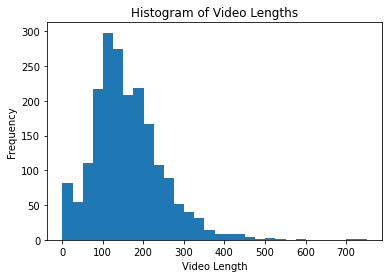

In [17]:
merged = pd.merge(s, phrases, on='sequence_id')
# Compute the lengths of the video sequences
video_lengths = merged.groupby('sequence_id').size()

# Plot the histogram
plt.hist(video_lengths, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Video Length')
plt.ylabel('Frequency')
plt.title('Histogram of Video Lengths')
plt.show()

In [18]:
# Determine the maximum sequence length
grouped = merged.groupby('sequence_id')
max_seq_length = 170

# Filter out IDs with more than 170 rows
filtered_df = grouped.filter(lambda x: len(x) <= max_seq_length)

In [19]:
# Create a new DataFrame to store the filled rows
filled_df = pd.DataFrame()
target = []


# Iterate over each group and fill remaining rows with zero
for _, group in filtered_df.groupby('sequence_id'):
    remaining_rows = max_seq_length - len(group)
    if remaining_rows > 0:
        zeros_df = pd.DataFrame([[0] * len(group.columns)] * remaining_rows, columns=group.columns)
        zeros_df['sequence_id'] = group['sequence_id'].unique()[0]
        zeros_df['phrase'] = group['phrase'].unique()[0]
        group = pd.concat([group, zeros_df])
    
    if (group["phrase"].unique()[0] not in target):
        filled_df = filled_df.append(group)
        target.append(group["phrase"].unique()[0])
    
filled_df.reset_index(drop=True, inplace=True)

In [20]:
len(target)

1209

In [21]:
set(filled_df.groupby('sequence_id').size().to_list())

{170}

In [22]:
del filled_df["sequence_id"] 
del filled_df["phrase"] 

In [23]:
# Convert each text in the list to numerical labels
numerical_labels_list = []
for text in target:
    numerical_labels = [char_to_pred[char] for char in text]
    numerical_labels_list.append(torch.tensor(numerical_labels))

# Pad the sequences to the maximum length
padded_labels = pad_sequence(numerical_labels_list, batch_first=True)

In [24]:
y = padded_labels #La variable respuesta
X = filled_df.fillna(0) #El resto de los datos

In [25]:
num_timesteps = max_seq_length
num_features = len(get_needed_cols())
num_classes = len(y)

In [26]:
expected_size =  num_classes * num_timesteps * num_features
actual_size = X.iloc[:, :num_features].values.size
if expected_size != actual_size:
    raise ValueError("The total number of elements in the DataFrame does not match the expected size.")

In [27]:
X = X.values.reshape(num_classes, num_timesteps, num_features)

In [28]:
X.shape

(1209, 170, 80)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [30]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (846, 170, 80) torch.Size([846, 30])
Test: (363, 170, 80) torch.Size([363, 30])


In [31]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

In [56]:
torch.cuda.empty_cache()

In [176]:
import torch.nn.functional as F

In [212]:
class ASLModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sequence_length):
        super(ASLModel, self).__init__()
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, input):
        print(input)
        batch_size = input.size(0)
        num_rows = input.size(1)
        num_cols = input.size(2)


        # Aplicar la capa de embedding
        embedded = self.embedding(input)
        print("embedded", embedded.size())
        
        # Reshape el embedding a (batch_size, seq_length, hidden_size)
        embedded = embedded.view(batch_size, num_rows * num_cols, -1)
        print("embedded 1 ", embedded.size())

        # Pasar la secuencia de entrada a través de la GRU
        output, _ = self.gru(embedded)
        print("output 1 ", output.size())

        # Obtener la última predicción de cada secuencia
        output = output[:, -1, :]
        # Utilizar la última salida de la GRU como entrada para la capa lineal
        output = self.fc(output)
        print("output 2", output.size())

        # # Replicar la salida para cada letra de la secuencia
        # Apply the softmax activation function
        output = F.softmax(output, dim=1)
        # print("output 3", output.size())

        return output



In [213]:

# Definir los parámetros del modelo
input_size = 59  # Número de letras posibles (0 a 27)
hidden_size = 32  # Tamaño de la capa oculta
output_size = 30  ## Longitud máxima de la secuencia de letras
sequence_length = 30  # Longitud máxima de la secuencia de letras

# Crear una instancia del modelo
model = ASLModel(input_size, hidden_size, output_size, sequence_length)

# Optimization Setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [214]:
print(X_train[0])

tensor([[0.3716, 0.7548, 0.0000,  ..., 0.6976, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3776, 0.7168, 0.0000,  ..., 0.6362, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [215]:
# Data Preparation
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

In [216]:
# Reverse the JSON dictionary
pred_to_char = {value: key for key, value in char_to_pred.items()}

In [217]:
def reverse_to_char(data):
    phrase = ""
    for i in data:
        phrase += str(pred_to_char.get(int(i.item())) if int(i.item()) in pred_to_char else "_")
    
    return phrase

In [218]:
EPOCHS = 5
loss_fn = nn.CrossEntropyLoss() 
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(EPOCHS):
    train_loss = 0.0

    # Iterar sobre los lotes de entrenamiento
    for batch in train_loader:
        # Obtener los datos de entrada y las etiquetas del lote
        inputs, labels = batch

        print(inputs[0])
        inputs = inputs * 10000
        inputs = torch.tensor(inputs, dtype=torch.long)
        print(inputs[0])
        labels = torch.tensor(labels, dtype=torch.float32)


        # Pasar los datos de entrada a través del modelo y obtener las predicciones
        outputs = model(inputs)
        predicted_indices = torch.argmax(outputs, dim=1)
        print(outputs)
        print(labels[0])

        # Calcular la pérdida
        loss = criterion(outputs, labels)

        # Realizar la retropropagación y la optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumular la pérdida total del entrenamiento
        train_loss += loss.item()
        break

    # Calcular la pérdida promedio del entrenamiento
    train_loss /= len(train_loader)

    # Imprimir información del entrenamiento
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss}')

tensor([[0.3716, 0.7548, 0.0000,  ..., 0.6976, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3776, 0.7168, 0.0000,  ..., 0.6362, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[3715, 7548,    0,  ..., 6975,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        [3776, 7168,    0,  ..., 6362,    0,    0],
        ...,
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0]])
tensor([[[3715, 7548,    0,  ..., 6975,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [3776, 7168,    0,  ..., 6362,    0,    0],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


IndexError: index out of range in self